# Policy search
Policy search RL algorithm for playing the game of Space Invaders.

In [23]:
# Import the environment
import ale_py
import gymnasium as gym
gym.register_envs(ale_py) # needed to run atari games

In [24]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical
import matplotlib.pyplot as plt

In [25]:
def preprocess_frame(frame):
    frame = frame[34:194] 
    frame = frame[::2, ::2, 0] 
    frame[frame == 144] = 0
    frame[frame == 109] = 0
    frame[frame != 0] = 1
    return np.expand_dims(frame.astype(np.float32), axis=0)

In [26]:
class PolicyNetwork(nn.Module):
    def __init__(self, action_space):
        super(PolicyNetwork, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2),
            nn.ReLU(),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, 256),  # Updated input size after CNN
            nn.ReLU(),
            nn.Linear(256, action_space)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return nn.Softmax(dim=-1)(x)

def compute_discounted_rewards(rewards, gamma):
    discounted_rewards = np.zeros_like(rewards)
    cumulative = 0
    for t in reversed(range(len(rewards))):
        cumulative = rewards[t] + gamma * cumulative
        discounted_rewards[t] = cumulative
    return discounted_rewards

Using device: cpu
Episode 10: Total Reward = 45.0, Average Reward = 131.5
Episode 20: Total Reward = 75.0, Average Reward = 182.5
Episode 30: Total Reward = 120.0, Average Reward = 128.5
Episode 40: Total Reward = 410.0, Average Reward = 165.0
Episode 50: Total Reward = 120.0, Average Reward = 116.0
Episode 60: Total Reward = 125.0, Average Reward = 99.5
Episode 70: Total Reward = 310.0, Average Reward = 149.0
Episode 80: Total Reward = 45.0, Average Reward = 86.5
Episode 90: Total Reward = 105.0, Average Reward = 172.0
Episode 100: Total Reward = 185.0, Average Reward = 198.0
Episode 110: Total Reward = 180.0, Average Reward = 109.5
Episode 120: Total Reward = 265.0, Average Reward = 139.0
Episode 130: Total Reward = 30.0, Average Reward = 99.0
Episode 140: Total Reward = 150.0, Average Reward = 122.5
Episode 150: Total Reward = 90.0, Average Reward = 146.0
Episode 160: Total Reward = 215.0, Average Reward = 154.0
Episode 170: Total Reward = 190.0, Average Reward = 202.0
Episode 180: 

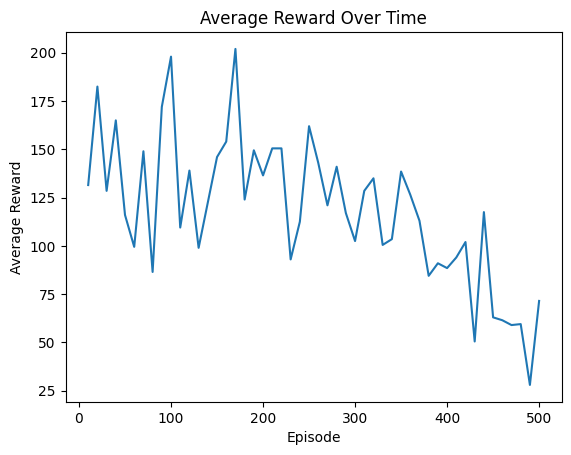

In [27]:
# Hyperparameters
env_name = 'ALE/SpaceInvaders-v5'
learning_rate = 1e-3
gamma = 0.99
num_episodes = 500
batch_size = 10  # Number of games to average gradients over
average_over = 10

env = gym.make(env_name, render_mode=None)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
policy = PolicyNetwork(env.action_space.n).to(device)
optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

episode_rewards = []
averaged_rewards = []
log_probs_batch = []
discounted_rewards_batch = []

for episode in range(num_episodes):
    state, _ = env.reset()
    state = preprocess_frame(state)
    state = torch.tensor(state, dtype=torch.float32, device=device)

    log_probs = []
    rewards = []

    done = False
    while not done:
        action_probs = policy(state.unsqueeze(0))
        dist = Categorical(action_probs)
        action = dist.sample()

        next_state, reward, done, _, _ = env.step(action.item())
        next_state = preprocess_frame(next_state)
        next_state = torch.tensor(next_state, dtype=torch.float32, device=device)

        log_probs.append(dist.log_prob(action))
        rewards.append(reward)

        state = next_state

    # Compute discounted rewards for the episode
    discounted_rewards = compute_discounted_rewards(rewards, gamma)
    discounted_rewards = torch.tensor(discounted_rewards, dtype=torch.float32, device=device)
    
    # Normalize rewards for stability
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-8)

    log_probs_batch.extend(log_probs)
    discounted_rewards_batch.extend(discounted_rewards)

    episode_rewards.append(sum(rewards))

    if (episode + 1) % batch_size == 0:
        # Compute batch loss
        log_probs_tensor = torch.stack(log_probs_batch)
        discounted_rewards_tensor = torch.stack(discounted_rewards_batch)
        loss = -torch.sum(log_probs_tensor * discounted_rewards_tensor) / batch_size

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Clear batch data
        log_probs_batch = []
        discounted_rewards_batch = []

    if (episode + 1) % average_over == 0:
        averaged_rewards.append(np.mean(episode_rewards[-average_over:]))
        print(f"Episode {episode + 1}: Total Reward = {sum(rewards)}, Average Reward = {averaged_rewards[-1]}")

# Plot averaged rewards
plt.plot(range(average_over, num_episodes + 1, average_over), averaged_rewards)
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Average Reward Over Time')
plt.show()

env.close()
